In [1]:
import sys
sys.path.append('../..')
from consecution import Node, Pipeline, GlobalState, Clock
from collections import namedtuple, defaultdict
import datetime
from dateutil.parser import parse
import glob
import csv
import itertools


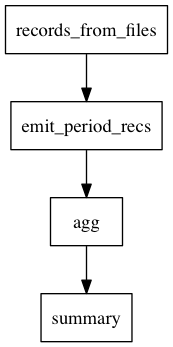

            tag_kind                 tag         mean_amount   transaction_count
--------------------------------------------------------------------------------
                hour                   8               35.71                1616
                hour                   9               38.97                1627
                hour                  10                45.7                1597
                hour                  11               49.62                1608
                hour                  12               52.66                1608
                hour                  13               61.79                1625
                hour                  14                61.7                1698
                hour                  15                67.1                1635
                hour                  16               72.24                1606
--------------------------------------------------------------------------------
             weekday        

In [23]:
Rec = namedtuple('Rec', 'time amount')
Key = namedtuple('Key', 'kind val')
TagRec = namedtuple('TagRec', 'time amount tag')
AggRec = namedtuple('AggRec', 'key sum_val count_val')
SummaryRec = namedtuple('SummaryRec', 'tag_kind tag mean count')


class RecordsFromFiles(Node):
    def process(self, file_name):
        with open(file_name) as in_file:
            for row in csv.DictReader(in_file):
                t = row['time']
                row['time'] = datetime.datetime(*[int(s) for s in t[:4], t[5:7], t[8:10], t[11:13]])
                row['amount'] = float(row['amount'])
                self.push(Rec(**row))

                
class EmitPeriodRecs(Node):
    def process(self, rec):
        self.push(TagRec(time=rec.time.hour, amount=rec.amount, tag='hour'))
        day_tag = '2_mon 3_tue 4_wed 5_thu 6_fri 7_sat 1_sun'.split()[rec.time.weekday()]
        self.push(TagRec(time=day_tag, amount=rec.amount, tag='weekday'))

class Agg(Node):
    def begin(self):
        self.sum_val_for = defaultdict(lambda: 0)
        self.count_val_for = defaultdict(lambda: 0)
        
    def get_key(self, rec):
        return Key(kind=rec.tag, val=rec.time)
    
    def process(self, rec):
        key = self.get_key(rec)
        self.sum_val_for[key] += rec.amount
        self.count_val_for[key] += 1

    def end(self):
        for key in sorted(self.sum_val_for.keys()):
            self.push(
                AggRec(key, self.sum_val_for[key], self.count_val_for[key])
            )
    
class Summary(Node):
    def process(self, rec):
        self.global_state.summary_rows.append(
            SummaryRec(
                tag_kind=rec.key.kind,
                tag=rec.key.val,
                mean=round(rec.sum_val / float(rec.count_val), 2),
                count=rec.count_val
            ))
    
        
class Printer(Node):
    def process(self, rec):
        print rec

class CashPipeline(Pipeline):
    def begin(self):
        self.global_state.clock = Clock()
        self.global_state.clock.start('pipeline')
        self.global_state.summary_rows = []
        
    def end(self):
        self.global_state.clock.stop('pipeline')
                

        return self.global_state.summary_rows
            
def print_results(results):
    columns = 'tag_kind tag mean_amount transaction_count'.split()
    template = '{:>20}' * 4 + '\n'
    sys.stdout.write(template.format(*columns))
    last_kind = None
    for kind, result_batch in itertools.groupby(sorted(results), lambda r: r.tag_kind):
        print '-' * 80
        for result in result_batch:
            sys.stdout.write(template.format(*result))
                
pipe = CashPipeline(
    RecordsFromFiles('records_from_files')
    | EmitPeriodRecs('emit_period_recs')
    | Agg('agg')
    | Summary('summary')
)
pipe.plot(display_noteook=True)
results = pipe.consume(glob.glob('cash_flows*.csv'))
print_results(results)
print pipe.global_state.clock




Pipeline
--------------------------------------------------------------------
     records_from_files | emit_period_recs
       emit_period_recs | [agg, tag_debit_credit]
                    agg | summary
       tag_debit_credit | tag_debit_credit.router
tag_debit_credit.router | [credit_agg, debit_agg]
              debit_agg | summary
             credit_agg | summary
--------------------------------------------------------------------



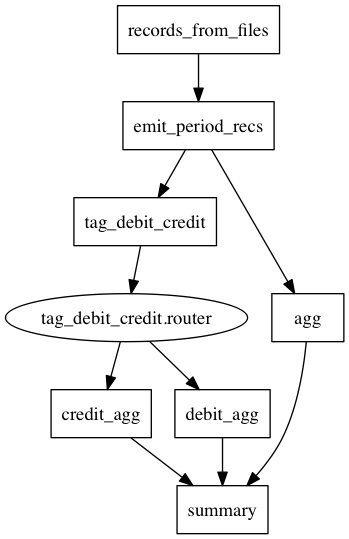

            tag_kind                 tag         mean_amount   transaction_count
--------------------------------------------------------------------------------
         credit_hour                   8               66.64                 593
         credit_hour                   9               68.04                 562
         credit_hour                  10               67.28                 513
         credit_hour                  11               62.22                 488
         credit_hour                  12               62.08                 497
         credit_hour                  13               64.21                 428
         credit_hour                  14                60.6                 453
         credit_hour                  15                57.5                 412
         credit_hour                  16               55.56                 378
--------------------------------------------------------------------------------
      credit_weekday        

In [22]:
#from math import abs
class TagDebitCredit(Node):
    def process(self, rec):
        kind = 'debit' if rec.amount >=0 else 'credit'
        positive_amount = abs(rec.amount)
        self.push(rec._replace(
                tag='{}_{}'.format(kind, rec.tag),
                amount=positive_amount,
            ))
        
def router(rec):
    if rec.tag.startswith('debit'):
        return 'debit_agg'
    else:
        return 'credit_agg'

pipe = CashPipeline(
    RecordsFromFiles('records_from_files')
    | EmitPeriodRecs('emit_period_recs')
      | [
            Agg('agg'),
            TagDebitCredit('tag_debit_credit') | [Agg('debit_agg'), Agg('credit_agg'), router]
        ]
    | Summary('summary')
)

    
print pipe
pipe.plot(display_noteook=True)
results = pipe.consume(glob.glob('cash_flows*.csv'))
print_results(results)
print pipe.global_state.clock


In [9]:
s = '2016-01-01 08:05:59'

In [18]:
year, month, day, hour = s[:4], s[5:7], s[8:10], s[11:13]